In [1]:
#deal with tensors
import torch   

#handling text data
from torchtext import data

#Ignore printing warnings
import warnings; 
warnings.filterwarnings('ignore')

In [2]:
#Reproducing same results
SEED = 2019

#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True  

In [3]:
TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True, lower=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)

In [4]:
fields = [(None, None), ('label', LABEL),(None, None), ('text',TEXT)]

Loading Twitter CSV Dataset. Download the dataset from [here](http://thinknook.com/wp-content/uploads/2012/09/Sentiment-Analysis-Dataset.zip)

In [5]:
#loading custom dataset
training_data=data.TabularDataset(path = 'Sentiment Analysis Dataset.csv', format = 'csv',fields = fields,skip_header = True)

print(vars(training_data.examples[0]))

{'label': '0', 'text': ['                     ', 'is', 'so', 'sad', 'for', 'my', 'apl', 'friend', '.............']}


Checking if dataset is balanced

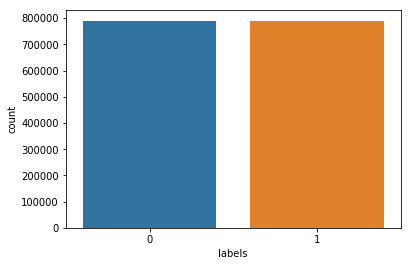

In [9]:
import seaborn as sns
from pandas import DataFrame

df = DataFrame ([vars(i)['label'] for i in training_data.examples],columns=['labels'])
ax = sns.countplot(x="labels", data=df)

In [10]:
import random
train_data, valid_data = training_data.split(split_ratio=0.7, random_state = random.seed(SEED))

In [11]:
#initialize glove embeddings
TEXT.build_vocab(train_data,min_freq=3,vectors = "glove.6B.100d")  
LABEL.build_vocab(train_data)

#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  

#Word dictionary
#print(TEXT.vocab.stoi)   

.vector_cache\glove.6B.zip: 862MB [06:39, 2.16MB/s]                                                                    
100%|██████████████████████████████████████████████████████████████████████▊| 399101/400000 [00:24<00:00, 18006.05it/s]

Size of TEXT vocabulary: 109437
Size of LABEL vocabulary: 2
[('i', 694311), ('!', 628174), ('.', 564920), (' ', 407152), ('to', 391915), ('the', 363919), (',', 336946), ('a', 265086), ('my', 219386), ('it', 211617)]


100%|██████████████████████████████████████████████████████████████████████▊| 399101/400000 [00:40<00:00, 18006.05it/s]

In [76]:
print(LABEL.vocab.stoi)

defaultdict(None, {'1': 0, '0': 1})


In [57]:
#check whether cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

#set batch size
BATCH_SIZE = 64

#Load an iterator
train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_data, valid_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

In [58]:
import torch.nn as nn

class classifier(nn.Module):
    
    #define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout):
        
        #Constructor
        super().__init__()          
        
        #embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm layer
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        
        #dense layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        #activation function
        self.act = nn.Sigmoid()
        
    def forward(self, text, text_lengths):
        
        #text = [batch size,sent_length]
        embedded = self.embedding(text)
        #embedded = [batch size, sent_len, emb dim]
      
        #packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
        
        #concat the final forward and backward hidden state
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
                
        #hidden = [batch size, hid dim * num directions]
        dense_outputs=self.fc(hidden)

        #Final activation function
        outputs=self.act(dense_outputs)
        
        return outputs

In [59]:
#define hyperparameters
size_of_vocab = len(TEXT.vocab)
embedding_dim = 100
num_hidden_nodes = 32
num_output_nodes = 1
num_layers = 2
bidirection = True
dropout = 0.2

#instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes,num_output_nodes, num_layers, 
                   bidirectional = True, dropout = dropout)

In [60]:
#architecture
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

#Initialize the pretrained embedding
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

print(pretrained_embeddings.shape)

classifier(
  (embedding): Embedding(109437, 100)
  (lstm): LSTM(100, 32, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (act): Sigmoid()
)
The model has 11,003,157 trainable parameters
torch.Size([109437, 100])


In [61]:
import torch.optim as optim

#define optimizer and loss
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

#define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
#push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [62]:
def train(model, iterator, optimizer, criterion):
    
    #initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    #set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        #resets the gradients after every batch
        optimizer.zero_grad()   
        
        #retrieve text and no. of words
        text, text_lengths = batch.text   
        
        #convert to 1D tensor
        predictions = model(text, text_lengths).squeeze()  
        
        #compute the loss
        loss = criterion(predictions, batch.label)        
        
        #compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        
        #backpropage the loss and compute the gradients
        loss.backward()       
        
        #update the weights
        optimizer.step()      
        
        #loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [63]:
def evaluate(model, iterator, criterion):
    
    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    #deactivating dropout layers
    model.eval()
    
    #deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            #retrieve text and no. of words
            text, text_lengths = batch.text
            
            #convert to 1d tensor
            predictions = model(text, text_lengths).squeeze()
            
            #compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            
            #keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [64]:
N_EPOCHS = 5
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
     
    #train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    #evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

	Train Loss: 0.372 | Train Acc: 83.32%
	 Val. Loss: 0.336 |  Val. Acc: 85.31%
	Train Loss: 0.300 | Train Acc: 87.25%
	 Val. Loss: 0.329 |  Val. Acc: 85.83%
	Train Loss: 0.261 | Train Acc: 89.11%
	 Val. Loss: 0.340 |  Val. Acc: 85.62%
	Train Loss: 0.228 | Train Acc: 90.73%
	 Val. Loss: 0.359 |  Val. Acc: 85.31%
	Train Loss: 0.199 | Train Acc: 92.02%
	 Val. Loss: 0.392 |  Val. Acc: 84.88%


In [77]:
#load weights
path='saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();

#inference 
import spacy
nlp = spacy.load('en')

def predict(model, sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]  #tokenize the sentence 
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]          #convert to integer sequence
    length = [len(indexed)]                                    #compute no. of words
    tensor = torch.LongTensor(indexed).to(device)              #convert to tensor
    tensor = tensor.unsqueeze(1).T                             #reshape in form of batch,no. of words
    length_tensor = torch.LongTensor(length)                   #convert to tensor
    prediction = model(tensor, length_tensor)                  #prediction 
    return 1-prediction.item()   

In [78]:
#make predictions
predict(model, "this weekend sucked so far")

0.01340705156326294

In [80]:
#insincere question
predict(model, "I love everybody.")

0.9550377205014229